In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict, Counter

from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, NMF, SlopeOne, NormalPredictor, KNNBaseline, KNNBasic
from surprise import KNNWithMeans, BaselineOnly, CoClustering

from surprise.model_selection import GridSearchCV, KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read in data
apr = pd.read_csv('/kaggle/input/recommendation/apr.csv')
apr.drop('Unnamed: 0', axis=1, inplace=True)

# Check for duplicated reviews
duplicated = apr[apr.duplicated(['customer_id', 'product_id'], keep=False)]

# Display duplicated
print('Number of duplications: {}'.format(duplicated.shape[0]))
pd.concat([apr[apr.duplicated(['customer_id', 'product_id'], keep=False)].head(2),
           apr[apr.duplicated(['customer_id', 'product_id'], keep=False)].tail(4)]
         )

Number of duplications: 20761


,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
16,48145149,R2UT2YCJ1GBHC6,1563890119,763187671,The Sandman Vol. 1: Preludes and Nocturnes,Books,5.0,1.0,2.0,3.0,N,"Oh come on people, four stars?",This introduction to the greatest graphic nove...,2001-04-30,137
17,48145149,R14L493O2SFWSP,1563890119,763187671,The Sandman Vol. 1: Preludes and Nocturnes,Books,5.0,0.0,2.0,2.0,N,"Oh come on people, four stars?",This introduction to the greatest graphic nove...,2001-04-30,137
5793935,20737814,R11K8F0EPST8AP,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,4.0,0.0,0.0,0.0,Y,Manning journey,"This game has smaller than usual tiles, which ...",2015-05-29,4679
5793937,20737814,R17BCBKI22FRDK,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,4.0,0.0,0.0,0.0,Y,Manning journey,"This game has smaller than usual tiles, which ...",2015-05-29,4679
5794615,25991980,RT4W1XPENOBYY,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,5.0,0.0,0.0,0.0,Y,Great version of Mahjong,I like this Mahjong better than he other 3 I h...,2015-06-06,4679
5794616,25991980,R3K6SZ04OJ9E62,B00VRYCGLO,183194229,Mahjong Journey®,Mobile Apps,5.0,0.0,0.0,0.0,Y,Great version of Mahjong,I like this Mahjong better than he other 3 I h...,2015-06-06,4679


In [3]:
# Drop duplicates
apr = apr[~apr.duplicated(['customer_id', 'product_id'], keep=False)].reset_index().drop('index', axis=1)

# Sort apr by customer_id and reset index
apr = apr.set_index('customer_id').sort_values('customer_id')
apr = apr.reset_index()

apr.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,downvotes,total_votes,verified_purchase,review_headline,review_body,review_date,purchased_counts
0,10001,R355MHM0X7RJ1V,B007SPPANM,764225016,Titanic,Video DVD,5.0,1.0,1.0,2.0,N,Best movie,best movie of all time!!!!!!!! Leonardo is ama...,2012-10-20,230
1,10001,R1O7YFSVGERAL5,B000FBFN1U,549456361,"A Storm of Swords (A Song of Ice and Fire, Boo...",Digital eBook Purchase,5.0,0.0,0.0,0.0,Y,Great read,Remarkable storytelling! Off to start next boo...,2012-12-31,2224
2,10018,R2LQC6HFQIOETX,B007R11DKQ,855352034,Stardust,Digital Video Download,4.0,0.0,0.0,0.0,N,South City Review,"Great Movie, Enjoyed every minute. Big fun of ...",2014-04-09,1270
3,10020,R19QPW7C4I7BOM,B004T0E2S8,614617161,Ultimate Guitar Tabs,Mobile Apps,5.0,0.0,0.0,0.0,Y,this app is AWESOME!!!,On the go without an Internet connection??? Do...,2014-07-26,246
4,10022,R36JURELK6GBA7,B00KNWYDU8,779873629,Dragon City,Mobile Apps,5.0,0.0,0.0,0.0,Y,awesome,This game Occupies me all the time I love it,2015-08-27,4840


In [4]:
# Count how many times a customer purchased a product
counts = apr['customer_id'].value_counts()

# Apply count filtering
multiple = apr[apr['customer_id'].isin(counts.index[counts>1])].reset_index().drop('index', axis=1)
several = apr[apr['customer_id'].isin(counts.index[counts>2])].reset_index().drop('index', axis=1)
many = apr[apr['customer_id'].isin(counts.index[counts>3])].reset_index().drop('index', axis=1)

# APR
print('Size of apr: {:,}'.format(len(apr)))
print('Unique apr customers: {:,}'.format(len(apr.customer_id.unique())))
print('Unique apr products: {:,}'.format(len(apr.product_id.unique())))
print('\n')

# Multiple
print('Size of multiple: {:,}'.format(len(multiple)))
print('Unique multiple customers: {:,}'.format(len(multiple.customer_id.unique())))
print('Unique multiple products: {:,}'.format(len(multiple.product_id.unique())))
print('\n')

# Several
print('Size of several: {:,}'.format(len(several)))
print('Unique several customers: {:,}'.format(len(several.customer_id.unique())))
print('Unique several products: {:,}'.format(len(several.product_id.unique())))
print('\n')

# Many
print('Size of many: {:,}'.format(len(many)))
print('Unique many customers: {:,}'.format(len(many.customer_id.unique())))
print('Unique many products: {:,}'.format(len(many.product_id.unique())))

Size of apr: 5,813,109
Unique apr customers: 3,649,861
Unique apr products: 11,502


Size of multiple: 3,091,744
Unique multiple customers: 928,496
Unique multiple products: 11,502


Size of several: 2,025,112
Unique several customers: 395,180
Unique several products: 11,502


Size of many: 1,470,094
Unique many customers: 210,174
Unique many products: 11,502


In [21]:
np.random.seed(10)
pivot = apr.iloc[np.random.choice(apr.index, size=10000, replace=False, )].pivot_table(
    index='customer_id', columns='product_id', values='star_rating', aggfunc='mean')

pivot.head(10)

product_id,0007466064,0060005424,0060005696,0060007737,0060090367,0060090383,006016848X,0060194995,0060245867,0060254920,...,B00XOXDXV8,B00XQ141W8,B00XWUNIXQ,B00Y3IOI7G,B00Y6QF0PE,B00YN6XHMU,B00ZZ08Q1K,B0100OQ9V4,B011KKCQH8,B011KKE5OK
customer_id,,,,,,,,,,,,,,,,,,,,,
10551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def missing(dataset):
    columns = dataset.columns
    print('TOTAL RATINGS per PRODUCT: {}'.format(len(dataset)))
    print('MISSING RATINGS per PRODUCT')
    for column in columns:
        percentage = (dataset[column].isnull().sum() / len(dataset)) * 100
        print('{}: {}, {:0.2f}%'.format(column, dataset[column].isnull().sum(), percentage))
        if percentage < 99.99:
            break
        
def missing_row(dataset):
    indexes = dataset.index
    print('TOTAL RATINGS per CUSTOMER: {}'.format(len(dataset.columns)))
    print('MISSINGS RATINGS per CUSTOMER')
    for index in indexes:
        percentage = (dataset.loc[index].isnull().sum() / len(dataset.columns)) * 100
        print('{}: {}, {:0.2f}%'.format(index, dataset.loc[index].isnull().sum(), percentage))
        if index == 17858:
            break

In [23]:
missing(pivot)

TOTAL RATINGS per PRODUCT: 96965
MISSING RATINGS per PRODUCT
0007466064: 96964, 100.00%
0060005424: 96962, 100.00%
0060005696: 96963, 100.00%
0060007737: 96962, 100.00%
0060090367: 96963, 100.00%
0060090383: 96964, 100.00%
006016848X: 96961, 100.00%
0060194995: 96962, 100.00%
0060245867: 96959, 99.99%
0060254920: 96942, 99.98%


In [24]:
missing_row(pivot)

TOTAL RATINGS per CUSTOMER: 10948
MISSINGS RATINGS per CUSTOMER
10551: 10947, 99.99%
10902: 10947, 99.99%
12527: 10947, 99.99%
12740: 10947, 99.99%
12940: 10947, 99.99%
13303: 10947, 99.99%
13612: 10947, 99.99%
15716: 10947, 99.99%
15978: 10947, 99.99%
16249: 10947, 99.99%
17858: 10947, 99.99%


In [25]:
# Find customers with the most purchases
customers = many.groupby('customer_id')['star_rating'].count()
top_customers = customers.sort_values(ascending=False)[:250]

# Find products with the most purchases
products = many.groupby('product_id')['star_rating'].count()
top_products = products.sort_values(ascending=False)[:10]

# Combine the datasets
join1 = many.join(top_customers, on='customer_id', how='inner', rsuffix='_r')
join1 = join1.join(top_products, on='product_id', how='inner', rsuffix='_r')

# Pivot the datset into a matrix
top_cust_prod = pd.crosstab(join1.customer_id, join1.product_id, join1.star_rating, aggfunc=np.mean)
top_cust_prod

product_id,B005ZOBNOI,B0063IH60K,B006LSZECO,B0094BB4TW,B00992CF6W,B00BAXFECK,B00DJFIMW6,B00E8KLWB4,B00FAPF5U0,B00L9B7IKE
customer_id,,,,,,,,,,
5291529,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN
11877567,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
14535682,NaN,5.0,NaN,5.0,5.0,NaN,4.0,2.0,5.0,NaN
27626904,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31612235,NaN,NaN,NaN,2.0,NaN,NaN,5.0,NaN,5.0,NaN
40079136,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
42418272,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN
44834233,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
46671309,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN


In [5]:
# Take random sample of ratings from dataset
np.random.seed(10)
apr_ = apr.iloc[np.random.choice(apr.index, size=5000, replace=False)]

# Set up rating scale and load data to be trained
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr_[['customer_id', 'product_title', 'star_rating']], reader)

In [6]:
%%time

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), 
                  KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
CPU times: user 6.24 s, sys: 1.41 s, total: 7.65 s
Wall time: 7.63 s


<timed exec>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.144043,0.058014,0.011019
SVD,1.144680,0.074186,0.010671
BaselineOnly,1.144884,0.021557,0.010963
KNNBaseline,1.145877,0.269919,0.011951
CoClustering,1.156865,0.551732,0.009549
KNNBasic,1.156955,0.252211,0.013680
KNNWithMeans,1.157075,0.326207,0.012787
NMF,1.157230,0.471297,0.011916
SlopeOne,1.158028,0.084645,0.015069


SVD gives the best RMSE so we will move along with SVD.  First we will evaluate this algorithm by cross validating it 3 times in the default settings.

In [6]:
# Cross validate default algorithm
algo = SVD(n_factors=100,
            n_epochs=20,
            biased=True,
            init_mean=0,
            init_std_dev=0.1,
            lr_all=0.005,
            reg_all=0.02,
            lr_bu=None,
            lr_bi=None,
            lr_pu=None,
            lr_qi=None,
            reg_bu=None,
            reg_bi=None,
            reg_pu=None,
            reg_qi=None,
            random_state=10)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([1.11260053, 1.18879135, 1.13250318]),
 'fit_time': (0.0703880786895752, 0.06550359725952148, 0.07068729400634766),
 'test_time': (0.011178731918334961,
  0.01076507568359375,
  0.010304689407348633)}

We will now take a random sample of 10000 ratings, although all products aren't represented in the sample, and we will tune our algorithm to the 10000 ratings to see if we can get a better RMSE score for the whole dataset.  In doing this we split the dataset randomly in to train and test, then load and fit the data.  We then perform a gridsearch in order to find the best hyperparameters for a 10000 rating dataset and apply it to the whole dataset.

In [5]:
# Take random sample of ratings from dataset
np.random.seed(10)
apr_ = apr.iloc[np.random.choice(apr.index, size=10000, replace=False)]

# Shuffle the index of apr dataset for random split
idx = np.array(apr_.index, dtype='int')
np.random.shuffle(idx)

# Start train-test-split with 80%-20% ratio
train = apr_.loc[idx[:int(0.75*len(idx))],['customer_id', 'product_title', 'star_rating']]
test = apr_.loc[idx[int(0.75*len(idx)):],['customer_id', 'product_title', 'star_rating']]

print("# of users in total:" , apr_.customer_id.nunique())
print("# of users in the training set: ", train.customer_id.nunique())
print("# of products in total:" , apr_.product_id.nunique())
print("# of products in the training set: ", train.product_title.nunique())

# of users in total: 9965
# of users in the training set:  7486
# of products in total: 4464
# of products in the training set:  3252


In [6]:
# Load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
# Load trainset, note: the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(train, reader)

# Prepare a trainset object out of the training data to feed to .fit() method
training = data_train.build_full_trainset()

# Load testset
data_test = Dataset.load_from_df(test, reader)

# Prepare a testset object out of the test data to feed to .test() method
testing = data_test.construct_testset(data_test.raw_ratings)

<a id='hyperparameter'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Hyperparameter Tuning

In [9]:
%%time

# Hyperparameter optimization with scikit-surprise SVD algorithm

# Cross validation to optimize parameters of SVD with bias
param_grid = {'n_factors': [50,75,100,150], 
                'n_epochs': [10,20,50,100], 
                'lr_all': [0.002,0.005,0.007],
                'reg_all': [0.01,0.02,0.03,0.04]}

svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(3, random_state=10))
svd_gs.fit(data_train) # gridsesarch optimization on the trainset

# Best RMSE score
print(svd_gs.best_score)
# Combination of parameters that gave the best RMSE score
print(svd_gs.best_params)

{'rmse': 1.1193523328771364}
{'rmse': {'n_factors': 75, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.01}}
CPU times: user 1min 54s, sys: 7.37 ms, total: 1min 54s
Wall time: 1min 54s


The best hyperparameters for a 10000 rating dataset is shown above, and tested below.  We will now load the full dataset into a training and testing set and see if our tuned SVD algorithm performs better than the default algorithm.

In [10]:
%%time

# Update SVD model with optimized parameters
svd = SVD(n_factors=75, n_epochs=100, lr_all=0.002, reg_all=0.01, random_state=10)
svd.fit(training)
pred_svd = svd.test(testing)
print(accuracy.rmse(pred_svd))

RMSE: 1.1368
1.1368360057841682
CPU times: user 524 ms, sys: 0 ns, total: 524 ms
Wall time: 523 ms


<a id='testing'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Testing Tuned Algorithm vs. Default Algorithm

In [7]:
%%time

# Load full dataset and split into train and test set to test hyperparameter on large dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr[['customer_id', 'product_title', 'star_rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

CPU times: user 34.7 s, sys: 1.91 s, total: 36.6 s
Wall time: 36.6 s


In [8]:
# Test default algorithm
algo = SVD(random_state=10)
predictions = algo.fit(trainset).test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.0655
1.0654899625541343


In [9]:
%%time

# Test tuned algorithm
algo_tuned = SVD(n_factors=75, n_epochs=100, lr_all=0.002, reg_all=0.01, random_state=10)
predictions_tuned = algo_tuned.fit(trainset).test(testset)
print(accuracy.rmse(predictions_tuned))

RMSE: 1.0746
1.0745943259058615
CPU times: user 7min 58s, sys: 1.27 s, total: 7min 59s
Wall time: 7min 59s


The tuned algorithm performs worse on the full dataset so we will re-tune the hyperparameters and try again.

In [ ]:
%%time

# Test re-tuned algorithm
algo_tuned = SVD(n_factors=100, n_epochs=20, lr_all=0.007, reg_all=0.04, random_state=10)
predictions_tuned = algo_tuned.fit(trainset).test(testset)
print(accuracy.rmse(predictions_tuned))

We see that the re-tuned algorithm performs better than the default, so we'll move along with the specified hyperparameters from now on.

In [10]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

# Create dataset for prediction evaluation
df = pd.DataFrame(predictions_tuned, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [10]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
134960,10287773,Dexter: Season 4,5.0,5.0,{'was_impossible': False},19,355,0.0
427415,16445071,Ugly Love: A Novel,5.0,5.0,{'was_impossible': False},1,1760,0.0
132753,24888019,Unforgiven (Two-Disc Special Edition),5.0,5.0,{'was_impossible': False},132,87,0.0
627189,29032561,"The Walking Dead, Season 3",5.0,5.0,{'was_impossible': False},1,4498,0.0
185372,45704309,We're the Millers (DVD),5.0,5.0,{'was_impossible': False},6,350,0.0
627190,33359929,Castle: Season 1,5.0,5.0,{'was_impossible': False},21,494,0.0
556987,44067730,North and South (BBC),5.0,5.0,{'was_impossible': False},7,759,0.0
320075,1633744,Guess The Emoji,5.0,5.0,{'was_impossible': False},1,13229,0.0
965621,45972350,Pinterest,5.0,5.0,{'was_impossible': False},2,11508,0.0
842570,40873435,Spirited Away,5.0,5.0,{'was_impossible': False},4,1026,0.0


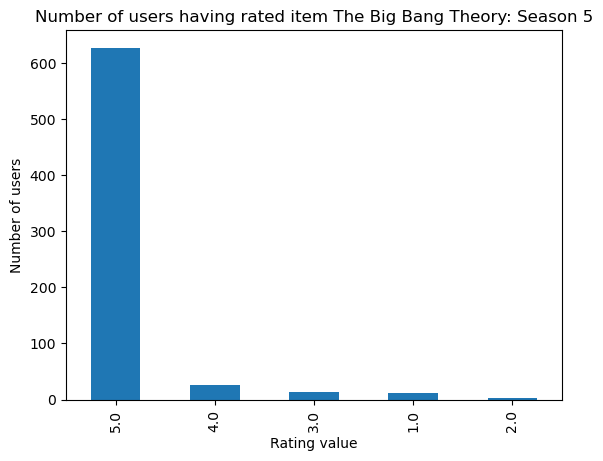

In [16]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('The Big Bang Theory: Season 5')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item The Big Bang Theory: Season 5')
plt.show()

In [11]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
185923,10379171,Led Zeppelin IV (aka ZOSO),1.0,5.0,{'was_impossible': False},4,647,4.0
140135,50420273,Captain Phillips,1.0,5.0,{'was_impossible': False},2,2592,4.0
140383,27218165,The Italian Job,1.0,5.0,{'was_impossible': False},129,296,4.0
1309641,19250317,Captain Phillips (Two Disc Combo: Blu-ray / DV...,1.0,5.0,{'was_impossible': False},2,310,4.0
269831,36853907,Can You Escape,1.0,5.0,{'was_impossible': False},2,12478,4.0
1248653,4066582,Pretty Little Liars,1.0,5.0,{'was_impossible': False},1,469,4.0
813917,29402593,Avatar (Original Theatrical Edition),1.0,5.0,{'was_impossible': False},6,680,4.0
102222,7609110,Hill Climb Racing,1.0,5.0,{'was_impossible': False},9,6162,4.0
774442,38386050,The Jungle Book - Animated (1967),1.0,5.0,{'was_impossible': False},2,82,4.0
23499,32904100,The Power of Now: A Guide to Spiritual Enlight...,1.0,5.0,{'was_impossible': False},1,2535,4.0


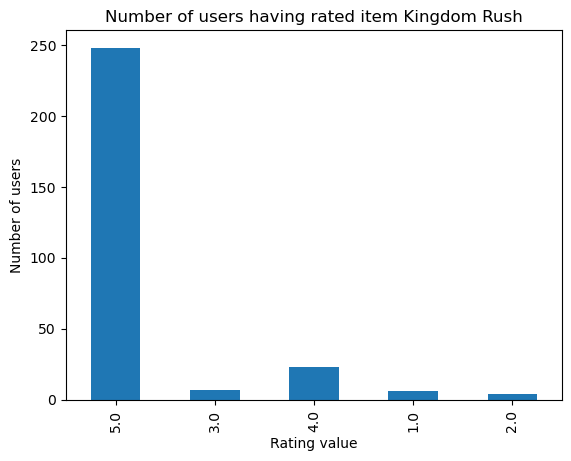

In [18]:
counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('Kingdom Rush')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item Kingdom Rush')
plt.show()

Below is the distribution of raw ratings vs. estimated ratings.  We can see that not all ratings are 1, 2, 3, 4 or 5 for estimated ratings but the distribution still follows a somewhat similar pattern.

In [ ]:
df[['rui', 'est']].plot(kind='hist', alpha=0.5)
plt.title('Estimated Ratings (est) vs True Ratings (rui)')
plt.show()

In [11]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [12]:
# Take a random sample of ratings from dataset
np.random.seed(10)
apr_ = apr.iloc[np.random.choice(apr.index, size=10000, replace=False)]

# 1000 is 6.22 secs
# 10000 is 7 min 10 secs
# 50000 over 3 hours and still not finished
# All - kernels die

# First train an SVD algorithm on the amazon customer reviews dataset.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr_[['customer_id', 'product_title', 'star_rating']], reader)
trainset = data.build_full_trainset()
algo = SVD(n_factors=100, n_epochs=20, lr_all=0.007, reg_all=0.04, random_state=10)
algo.fit(trainset)

In [14]:
%%time

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.2411
0.2411421362353418
CPU times: user 5min 57s, sys: 24.7 s, total: 6min 21s
Wall time: 6min 21s


Below we see the top 10 predictions for 5 customer ID's.  We'll turn the data into a dataframe.

In [15]:
# Find top n predictions
top_n = get_top_n(predictions, n=10)

# Print the recommended items for the first 5 users
counter = 0
for uid, user_ratings in top_n.items():
    if counter == 5:
        break
    print(uid, [iid for (iid, _) in user_ratings])
    counter += 1
    print('\n')

    
# Append recommended items for each user into a dictionary
top_items = {}
for uid, user_ratings in top_n.items():
    top_items[uid] = [iid for (iid, _) in user_ratings]

16344847 ['The Hunger Games (Hunger Games Trilogy, Book 1)', 'Downton Abbey Season 3', 'John Adams Season 1', 'Me Before You: A Novel', 'Band of Brothers Season 1', 'Suits Season 1', 'TuneIn Radio', 'Downton Abbey Season 5', 'Defending Jacob: A Novel', "Five Nights at Freddy's 2"]


30678701 ['Downton Abbey Season 3', 'The Pacific Season 1', 'The Hunger Games (Hunger Games Trilogy, Book 1)', 'Lone Survivor: The Eyewitness Account of Operation Redwing and the Lost Heroes of SEAL Team 10', 'Downton Abbey Season 5', 'Geometry Dash Lite', 'Wonder', "Five Nights at Freddy's", 'Sherlock Season 2', 'Firefly Season 1']


16465135 ['Downton Abbey Season 3', 'Band of Brothers Season 1', 'Crossy Road', 'The Hunger Games (Hunger Games Trilogy, Book 1)', 'The Room (Kindle Tablet Edition)', 'Downton Abbey Season 2', 'The Third Wheel (Diary of a Wimpy Kid, Book 7)', 'Amazon Underground', 'Me Before You: A Novel', 'John Adams Season 1']


45438862 ['Wonder', 'Hopeless', 'The Pacific Season 1', 'Downto

Below is a dataframe of our top 10 ratings for each customer ID, along with the customer's predicted ratings for the product.

In [16]:
recommended_w_ratings = pd.DataFrame.from_dict(top_n, orient='index')
recommended_w_ratings.head()

,0,1,2,3,4,5,6,7,8,9
16344847,"(The Hunger Games (Hunger Games Trilogy, Book ...","(Downton Abbey Season 3, 4.900347609925889)","(John Adams Season 1, 4.845003612820365)","(Me Before You: A Novel, 4.81854353869497)","(Band of Brothers Season 1, 4.7887700179517205)","(Suits Season 1, 4.778014007974196)","(TuneIn Radio, 4.766482839032318)","(Downton Abbey Season 5, 4.763049030886263)","(Defending Jacob: A Novel, 4.759979464784856)","(Five Nights at Freddy's 2, 4.757093535280311)"
30678701,"(Downton Abbey Season 3, 4.802539376502293)","(The Pacific Season 1, 4.72619072474924)","(The Hunger Games (Hunger Games Trilogy, Book ...",(Lone Survivor: The Eyewitness Account of Oper...,"(Downton Abbey Season 5, 4.687908580319665)","(Geometry Dash Lite, 4.664596452989186)","(Wonder, 4.658355071447615)","(Five Nights at Freddy's, 4.657501910135011)","(Sherlock Season 2, 4.649053538219418)","(Firefly Season 1, 4.642133538063709)"
16465135,"(Downton Abbey Season 3, 4.922477036291557)","(Band of Brothers Season 1, 4.872192006810055)","(Crossy Road, 4.835400370890903)","(The Hunger Games (Hunger Games Trilogy, Book ...","(The Room (Kindle Tablet Edition), 4.806700331...","(Downton Abbey Season 2, 4.806088614280652)","(The Third Wheel (Diary of a Wimpy Kid, Book 7...","(Amazon Underground, 4.78802571099864)","(Me Before You: A Novel, 4.783783390925335)","(John Adams Season 1, 4.783653341798226)"
45438862,"(Wonder, 4.992777341756024)","(Hopeless, 4.98681001560101)","(The Pacific Season 1, 4.966017198459856)","(Downton Abbey Season 3, 4.965416747581851)","(Crossy Road, 4.958280391767791)","(Me Before You: A Novel, 4.950539933579914)","(Firefly Season 1, 4.939410129966117)",(Lone Survivor: The Eyewitness Account of Oper...,"(Downton Abbey Season 4, 4.924693724003722)","(The Third Wheel (Diary of a Wimpy Kid, Book 7..."
35081900,"(Downton Abbey Season 3, 5)","(Crossy Road, 4.957932083457072)","(Me Before You: A Novel, 4.9098126796462065)","(Downton Abbey Season 5, 4.893141600858727)","(Five Nights at Freddy's, 4.869514455666185)",(A Dance with Dragons (A Song of Ice and Fire)...,"(Band of Brothers Season 1, 4.860383348292796)","(Evernote - stay organized., 4.855134108128775)","(John Adams Season 1, 4.843768425027998)","(My Horse, 4.836574726031152)"


Below is a dataframe of our top 10 ratings for each customer ID without predicted ratings for easier visualization.

In [17]:
recommended = pd.DataFrame.from_dict(top_items, orient='index')
recommended.head()

,0,1,2,3,4,5,6,7,8,9
16344847,"The Hunger Games (Hunger Games Trilogy, Book 1)",Downton Abbey Season 3,John Adams Season 1,Me Before You: A Novel,Band of Brothers Season 1,Suits Season 1,TuneIn Radio,Downton Abbey Season 5,Defending Jacob: A Novel,Five Nights at Freddy's 2
30678701,Downton Abbey Season 3,The Pacific Season 1,"The Hunger Games (Hunger Games Trilogy, Book 1)",Lone Survivor: The Eyewitness Account of Opera...,Downton Abbey Season 5,Geometry Dash Lite,Wonder,Five Nights at Freddy's,Sherlock Season 2,Firefly Season 1
16465135,Downton Abbey Season 3,Band of Brothers Season 1,Crossy Road,"The Hunger Games (Hunger Games Trilogy, Book 1)",The Room (Kindle Tablet Edition),Downton Abbey Season 2,"The Third Wheel (Diary of a Wimpy Kid, Book 7)",Amazon Underground,Me Before You: A Novel,John Adams Season 1
45438862,Wonder,Hopeless,The Pacific Season 1,Downton Abbey Season 3,Crossy Road,Me Before You: A Novel,Firefly Season 1,Lone Survivor: The Eyewitness Account of Opera...,Downton Abbey Season 4,"The Third Wheel (Diary of a Wimpy Kid, Book 7)"
35081900,Downton Abbey Season 3,Crossy Road,Me Before You: A Novel,Downton Abbey Season 5,Five Nights at Freddy's,A Dance with Dragons (A Song of Ice and Fire),Band of Brothers Season 1,Evernote - stay organized.,John Adams Season 1,My Horse


<a id='testing2'></a>
<a id='above2'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Testing Product Recommendations for Customers

We test how it would look to have the top 10 products recommended with and without the predicted ratings attached.  We find that without the ratings attached makes the recommender easier to read.

We first look at a customer ID in order to see how many previous ratings the customer had and then see how the recommendations are affected by each type of customer.

In [13]:
def products_recommended(user):
    print('The top 10 product recommendations for user {} is:'.format(user))
    return recommended.loc[user]

def products_recommended_w_rating(user):
    number = 0
    print('The top 10 product recommendations with estimated ratings for user {} is:'.format(user))
    for rating in recommended_w_ratings.loc[user]:
        print(number,' ', rating[0], ' : ', rating[1])
        number += 1

In [14]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Load sampled 10000 ratings dataset
data = Dataset.load_from_df(apr_[['customer_id', 'product_id', 'star_rating']], reader)
kf = KFold(n_splits=5)
algo = SVD(random_state=10)

print('Sampled 10000 Ratings \n')

number = 0
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('KFold Test #{}:'.format(number+1))
    print('Precision: {}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
    print('Recall: {}'.format(sum(rec for rec in recalls.values()) / len(recalls)))
    print('\n')
    number += 1

Sampled 10000 Ratings 

KFold Test #1:
Precision: 0.8557114228456913
Recall: 0.9679358717434869


KFold Test #2:
Precision: 0.845
Recall: 0.9565


KFold Test #3:
Precision: 0.8223223223223223
Recall: 0.965965965965966


KFold Test #4:
Precision: 0.8449224612306153
Recall: 0.9599799899949975


KFold Test #5:
Precision: 0.8415915915915916
Recall: 0.9574574574574575




In [20]:
# Load full dataset
data = Dataset.load_from_df(apr[['customer_id', 'product_id', 'star_rating']], reader)
kf = KFold(n_splits=5)
algo = SVD(random_state=10)

print('Full Dataset \n')
number = 0
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('KFold Test #{}:'.format(number+1))
    print('Precision: {}'.format(sum(prec for prec in precisions.values()) / len(precisions)))
    print('Recall: {}'.format(sum(rec for rec in recalls.values()) / len(recalls)))
    print('\n')
    number += 1

Full Dataset 

KFold Test #1:
Precision: 0.9005001566088227
Recall: 0.8705995812909934


KFold Test #2:
Precision: 0.9008590029372812
Recall: 0.8690938265449699


KFold Test #3:
Precision: 0.9012094778520168
Recall: 0.8694729673910461


KFold Test #4:
Precision: 0.9009671511393442
Recall: 0.8694656881732762


KFold Test #5:
Precision: 0.9021510740757444
Recall: 0.8655278934356118




We can see that the sampled predictions have fairly high precision scores and recall scores only a few points lower (3 points).  The full dataset of predictions have extremely high recall scores with precision scores much lower (11 points).  The sampled predictions are closer to consistency in recommending unseen items than the full predictions, but the full predictions are much more consistent in recommending seen items.

<a id='similar'></a>
<a href='#Table of Contents'>Table of Contents</a>

------------
## Recommending Similar Products

In recommending similar products we are using surprise to find the [k nearest neighbors of an item.](https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-k-nearest-neighbors-of-a-user-or-item)There’s a lot of boilerplate because of the conversions between product names and their raw/inner ids [(see this note)](https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note), but it all boils down to the use of [get_neighbors().](https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.get_neighbors)  

In this recommendation system, we not only recommend the products similar to a given product, but we display what product category the recommended product belongs to.  Some are obvious, but for recommending products similar to 'Chromecast,' it's best to know what product categories the recommended products belong to.  It is also worth noting that we are able to map out the full dataset to predict similar items, rather than just a sample.

In [15]:
# Create simple id to map products
apr['id'] = apr.groupby('product_id').ngroup()

# Train the algortihm to compute the similarities between items
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(apr[['customer_id', 'id', 'star_rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [16]:
# Read the mappings raw id <-> product name
rid_to_name = dict(zip(apr.id, apr.product_title))
name_to_rid = dict(zip(apr.product_title, apr.id))

<a id='test__1'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 1 - Minecraft

In [23]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Minecraft']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of Toy Story.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Minecraft are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Minecraft are:

0: Mobile Apps -  Bloons TD 5
1: Mobile Apps -  Angry Birds Epic RPG
2: Mobile Apps -  Twitter
3: Mobile Apps -  Farming Simulator 14
4: Mobile Apps -  Goat Simulator
5: Mobile Apps -  Head Soccer
6: Mobile Apps -  Asphalt 8: Airborne
7: Mobile Apps -  Hungry Shark Evolution
8: Mobile Apps -  The Dark Knight Rises (Kindle Tablet Edition)
9: Mobile Apps -  Dragon City


<a id='test__2'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 2 - Candy Crush Saga

In [25]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Candy Crush Saga']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Candy Crush Saga are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Candy Crush Saga are:

0: Mobile Apps -  Frozen Free Fall
1: Mobile Apps -  Candy Crush Soda Saga
2: Mobile Apps -  Pet Rescue Saga
3: Mobile Apps -  Farm Heroes Saga
4: Mobile Apps -  Booty Quest – match 3 jewels and challenge friends!
5: Mobile Apps -  8 Ball Pool
6: Mobile Apps -  TuneIn Radio
7: Mobile Apps -  Diamond Dash
8: Mobile Apps -  The Secret Society® - Hidden Mystery
9: Mobile Apps -  CSI: Hidden Crimes


<a id='test__3'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 3 - Game of Thrones Season 1

In [26]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Game of Thrones Season 1']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Game of Thrones Season 1 are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Game of Thrones Season 1 are:

0: Digital Video Download -  Game of Thrones Season 2
1: Digital Video Download -  Game of Thrones Season 2
2: Digital eBook Purchase -  A Clash of Kings (A Song of Ice and Fire, Book 2)
3: Digital Video Download -  Homeland Season 1
4: Digital Video Download -  Vikings Season 1
5: Digital eBook Purchase -  George R. R. Martin's A Game of Thrones 5-Book Boxed Set (Song of Ice and Fire Series): A Game of Thrones, A Clash of Kings, A Storm of Swords, A Feast for Crows, and A Dance with Dragons
6: Digital Video Download -  Brave
7: Digital Video Download -  Once Upon a Time Season 2
8: Digital Video Download -  The Walking Dead, Season 1
9: Digital Video Download -  Guardians of the Galaxy (Plus Bonus Features)


<a id='test__4'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 4 - Ted (Unrated)

In [27]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Ted (Unrated)']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Ted (Unrated) are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

The 10 most similar products to Ted (Unrated) are:

0: Digital Video Download -  The Dark Knight Rises
1: Video DVD -  Looper
2: Digital Video Download -  Noah
3: Digital Video Download -  The Hunger Games: Catching Fire
4: Digital Video Download -  Hope Springs
5: Digital Video Download -  Gravity
6: Digital Video Download -  The Walking Dead, Season 3
7: Home Entertainment -  Google Chromecast HDMI Streaming Media Player
8: Digital Video Download -  Despicable Me
9: Digital Video Download -  Godzilla (2014)


<a id='test__5'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 5 - Google Chromecast HDMI Streaming Media Player

In [ ]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['Google Chromecast HDMI Streaming Media Player']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to Google Chromecast HDMI Streaming Media Player are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

<a id='test__6'></a>
<a href='#Table of Contents'>Table of Contents</a>

### Test 6 - Lego Ghostbusters Ecto-1 21108

In [ ]:
# Retrieve inner id of the product
product_raw_id = name_to_rid['LEGO Ghostbusters Ecto-1 21108']
product_inner_id = algo.trainset.to_inner_iid(product_raw_id)

# Retrieve inner ids of the nearest neighbors of product.
product_neighbors = algo.get_neighbors(product_inner_id, k=10)

# Convert inner ids of the neighbors into names.
product_neighbors = (algo.trainset.to_raw_iid(inner_id)
                       for inner_id in product_neighbors)
product_neighbors = (rid_to_name[rid]
                       for rid in product_neighbors)

print('The 10 most similar products to LEGO Ghostbusters Ecto-1 21108 are:\n')
ranking = 0
for neighbor in product_neighbors:
    print('{}: {} - '.format(ranking, apr[apr['product_title'] == neighbor]['product_category'].iloc[0]), neighbor)
    ranking += 1

In [17]:
import pickle
pickle.dump(algo, open('model.pkl','wb'))

In [18]:
output = open('name_to_rid.pkl', 'wb')
pickle.dump(name_to_rid, output)

In [19]:
output = open('rid_to_name.pkl', 'wb')
pickle.dump(rid_to_name, output)